In [ ]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from lightgbm import LGBMRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [343]:
# Paths and schema
DATA_DIR = Path("models_store/Dataset")
PART_FILES = [DATA_DIR / "dataset_part1.csv"]

# Fallback: if running from the Dataset folder, look for files locally
if not all(p.exists() for p in PART_FILES):
    alt_dir = Path.cwd()
    alt_parts = [alt_dir / "dataset_part1.csv"]
    if all(p.exists() for p in alt_parts):
        DATA_DIR = alt_dir
        PART_FILES = alt_parts
    else:
        raise FileNotFoundError(
            f"Could not find dataset parts in {DATA_DIR} or {alt_dir}. "
            "Please check the working directory."
        )

ID_COL = "patient_id"
CATEGORICAL_COLS = ["sex", "primary_report_type"]
BINARY_FLAG_COLS = ["dengue_ns1", "dengue_igm", "malaria_rdt", "rapid_creatinine_rise_flag"]
TARGET_PROB_COLS = [
    "risk_ckd_prob",
    "risk_cad_prob",
    "risk_aki_prob",
    "risk_sepsis_prob",
    "risk_metabolic_syndrome_prob",
]
TARGET_LEVEL_COLS = [
    "risk_ckd_level",
    "risk_cad_level",
    "risk_aki_level",
    "risk_sepsis_level",
    "risk_metabolic_syndrome_level",
]
PROB_DISPLAY = {
    "risk_ckd_prob": "Chronic Kidney Disease Risk",
    "risk_cad_prob": "Coronary Artery Disease Risk",
    "risk_aki_prob": "Acute Kidney Injury Risk",
    "risk_sepsis_prob": "Sepsis / Severe Infection Risk",
    "risk_metabolic_syndrome_prob": "Metabolic Syndrome Risk",
}
RISK_LEVEL_ORDER = {"Low": 0, "Moderate": 1, "High": 2}
TRAINED_DIR = DATA_DIR.parent / "trained_models"
TRAINED_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42


def display_prob_name(col: str) -> str:
    """Return a human-friendly display name for probability targets."""
    return PROB_DISPLAY.get(col, col.replace("_", " ").title())


In [344]:
def load_parts(paths):
    frames = []
    for p in paths:
        if not p.exists():
            raise FileNotFoundError(f"Missing file: {p}")
        df_part = pd.read_csv(p)
        frames.append(df_part)
    df_all = pd.concat(frames, axis=0, ignore_index=True)
    df_all = df_all.drop_duplicates(subset=[ID_COL])
    return df_all


print("Using data dir:", DATA_DIR)
df = load_parts(PART_FILES)
print(f"Loaded {len(df):,} rows, {df.shape[1]} columns")
print(df["primary_report_type"].value_counts())


Using data dir: d:\Volume E\PROJECTS\GDG_KrakenTech\GDG_KRAKENTECH_MEDWHISPER\models_store\Dataset
Loaded 50,000 rows, 51 columns
primary_report_type
Diabetes        15133
Hypertension    12409
Infectious       9051
Cardiac          7447
General          5960
Name: count, dtype: int64


In [345]:
# Dataset overview
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes.value_counts()}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head(3)


DATASET OVERVIEW
Shape: (50000, 51)

Data Types:
float64    35
object      8
int64       8
Name: count, dtype: int64

Memory Usage: 36.75 MB

First few rows:


,patient_id,age,sex,bmi,primary_report_type,hemoglobin,wbc,platelets,creatinine,egfr,...,risk_ckd_prob,risk_ckd_level,risk_cad_prob,risk_cad_level,risk_aki_prob,risk_aki_level,risk_sepsis_prob,risk_sepsis_level,risk_metabolic_syndrome_prob,risk_metabolic_syndrome_level
0,P07000001,72,F,25.4,Infectious,15.9,0.684492,186256.0,1.820000,73.8,...,0.153999,Low,0.004189,Low,0.474332,Moderate,0.033178,Low,0.001000,Low
1,P07000002,38,M,21.3,Diabetes,12.1,4.000000,168984.0,1.174818,86.7,...,0.061078,Low,0.003051,Low,0.068788,Low,0.006228,Low,0.003109,Low
2,P07000003,46,M,21.4,Infectious,11.1,6.831468,208308.0,0.960000,103.1,...,0.002402,Low,0.003576,Low,0.112904,Low,0.132380,Low,0.001297,Low


## 1. Exploratory Data Analysis (EDA)

In [346]:
# Missing values analysis
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_summary = pd.DataFrame({
    'Missing_Count': df.isna().sum(),
    'Missing_Percentage': missing_pct * 100
}).sort_values('Missing_Percentage', ascending=False)

print(missing_summary[missing_summary['Missing_Percentage'] > 0].head(15))


MISSING VALUES ANALYSIS
                 Missing_Count  Missing_Percentage
ntprobnp                 34958              69.916
troponin_hs              29801              59.602
c_peptide                25047              50.094
insulin                  24955              49.910
urine_acr                20043              40.086
bilirubin_total           2538               5.076
ast                       1497               2.994
alt                       1465               2.930
crp                        972               1.944
wbc                        475               0.950
platelets                  249               0.498


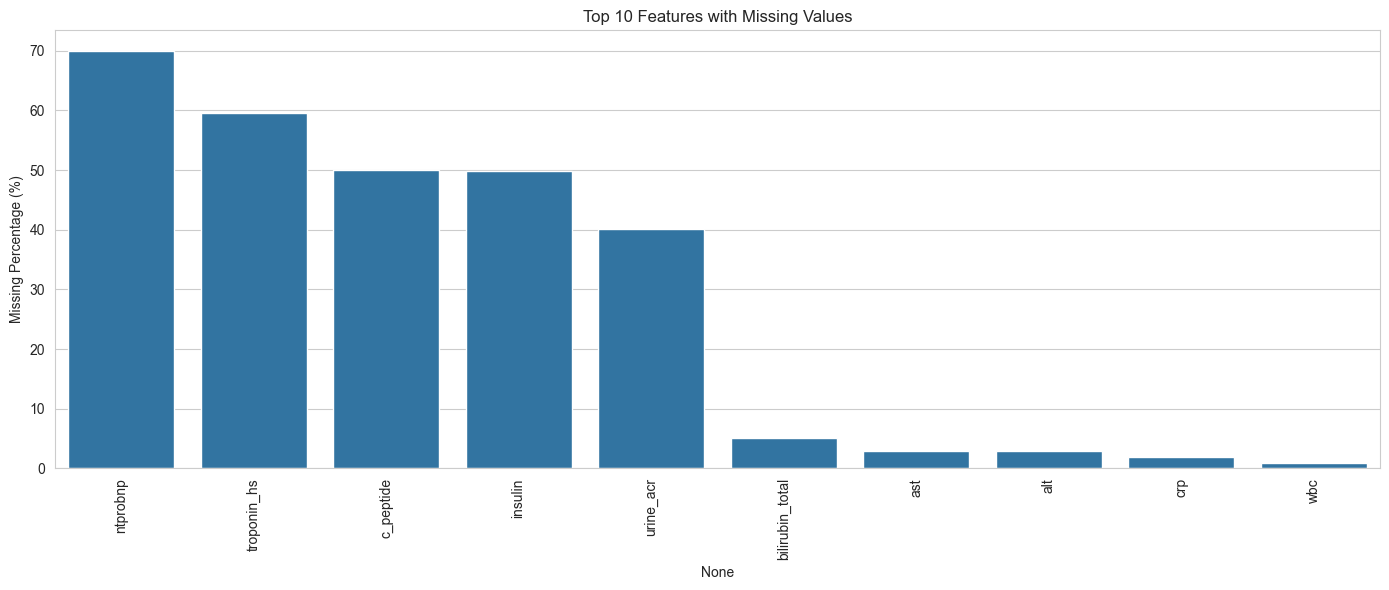

In [347]:
# Visualize missing values
plt.figure(figsize=(14, 6))
top_missing = missing_summary[missing_summary['Missing_Percentage'] > 0].head(10)
sns.barplot(x=top_missing.index, y=top_missing['Missing_Percentage'])
plt.xticks(rotation=90)
plt.title('Top 10 Features with Missing Values')
plt.ylabel('Missing Percentage (%)')
plt.tight_layout()
plt.show()


## 2. Data Preprocessing

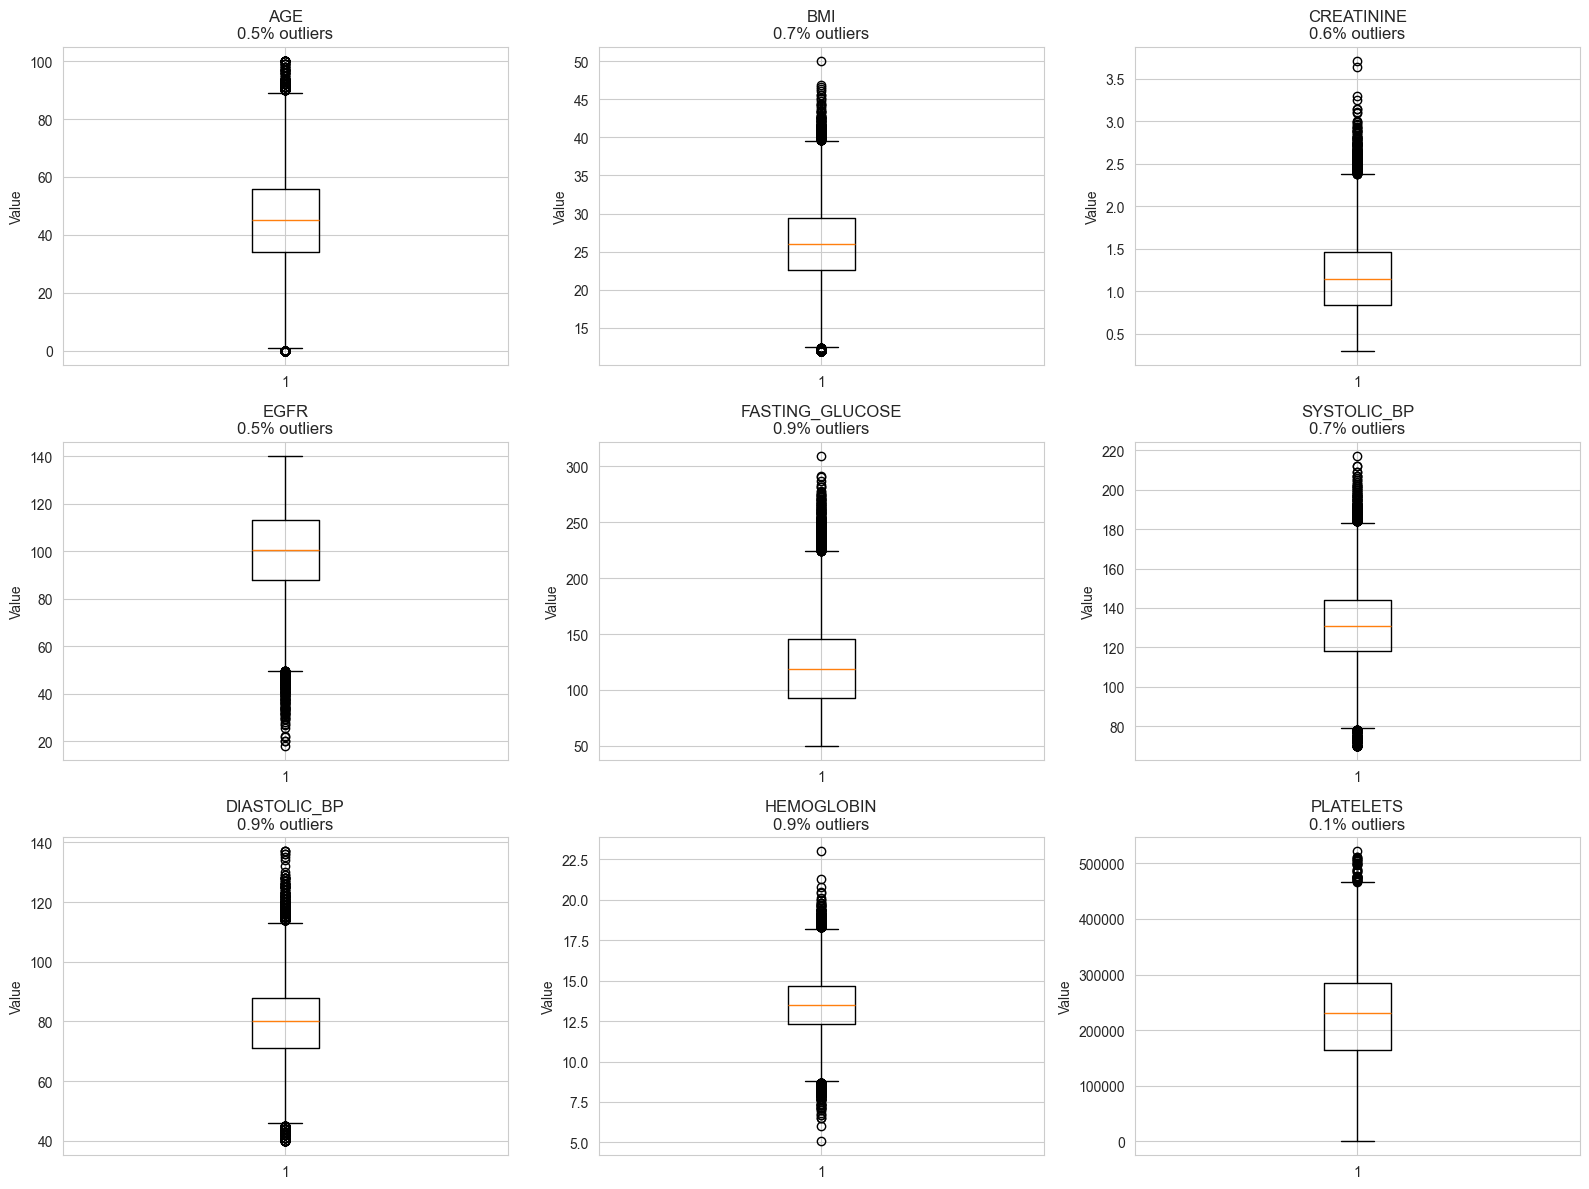

In [348]:
# Outlier detection for key features
outlier_features = ['age', 'bmi', 'creatinine', 'egfr', 'fasting_glucose', 
                    'systolic_bp', 'diastolic_bp', 'hemoglobin', 'platelets']
outlier_features = [f for f in outlier_features if f in df.columns]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

outlier_summary = []
for idx, col in enumerate(outlier_features):
    if idx < len(axes):
        data = df[col].dropna()
        
        # Calculate IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_pct = (len(outliers) / len(data)) * 100
        
        outlier_summary.append({
            'Feature': col,
            'Outliers': len(outliers),
            'Percentage': outlier_pct,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })
        
        # Box plot
        axes[idx].boxplot(data, vert=True)
        axes[idx].set_title(f'{col.upper()}\n{outlier_pct:.1f}% outliers')
        axes[idx].set_ylabel('Value')

for idx in range(len(outlier_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [349]:
# Outlier summary statistics
print("="*80)
print("OUTLIER DETECTION SUMMARY")
print("="*80)
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))


OUTLIER DETECTION SUMMARY
        Feature  Outliers  Percentage  Lower_Bound  Upper_Bound
            age       259     0.51800      1.00000     89.00000
            bmi       364     0.72800     12.40000     39.60000
     creatinine       291     0.58200     -0.08395      2.38439
           egfr       264     0.52800     49.60000    151.20000
fasting_glucose       444     0.88800     14.00000    224.40000
    systolic_bp       347     0.69400     79.00000    183.00000
   diastolic_bp       429     0.85800     45.50000    113.50000
     hemoglobin       436     0.87200      8.70000     18.30000
      platelets        39     0.07839 -16507.50000 466036.50000


CORRELATION WITH TARGET PROBABILITIES


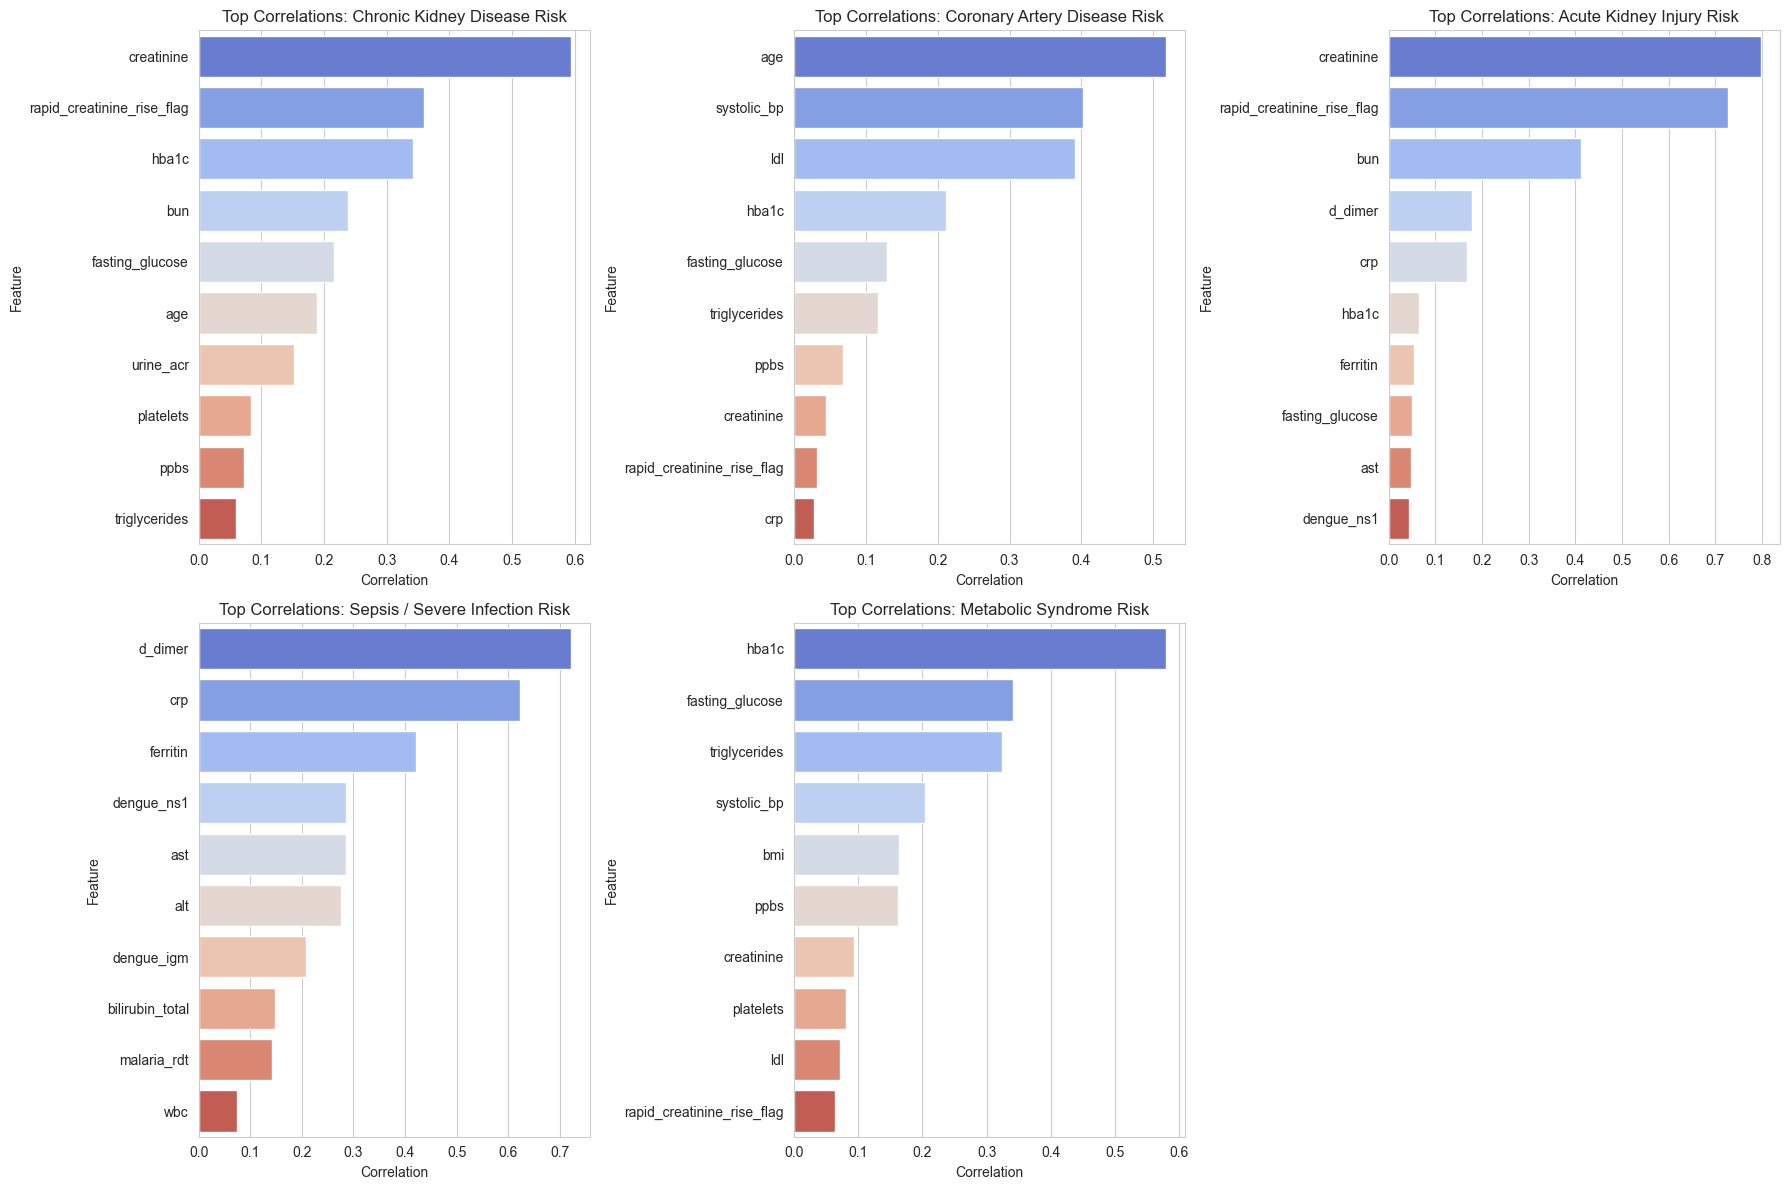

In [350]:
# Correlation analysis with target probabilities
print("="*80)
print("CORRELATION WITH TARGET PROBABILITIES")
print("="*80)

# Select numeric columns for correlation
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in TARGET_PROB_COLS + TARGET_LEVEL_COLS and f != ID_COL]

# Calculate correlations with each target
correlation_data = []
for target in TARGET_PROB_COLS:
    corr = df[numeric_features + [target]].corr()[target].drop(target).sort_values(ascending=False)
    top_corr = corr.head(10)
    correlation_data.append(pd.DataFrame({
        'Feature': top_corr.index,
        'Correlation': top_corr.values,
        'Target': target
    }))

all_corr = pd.concat(correlation_data)

# Plot top correlations for each target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, target in enumerate(TARGET_PROB_COLS):
    target_corr = all_corr[all_corr['Target'] == target].head(10)
    sns.barplot(data=target_corr, x='Correlation', y='Feature', ax=axes[idx], palette='coolwarm')
    axes[idx].set_title(f"Top Correlations: {display_prob_name(target)}")
    axes[idx].set_xlabel('Correlation')

if len(TARGET_PROB_COLS) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


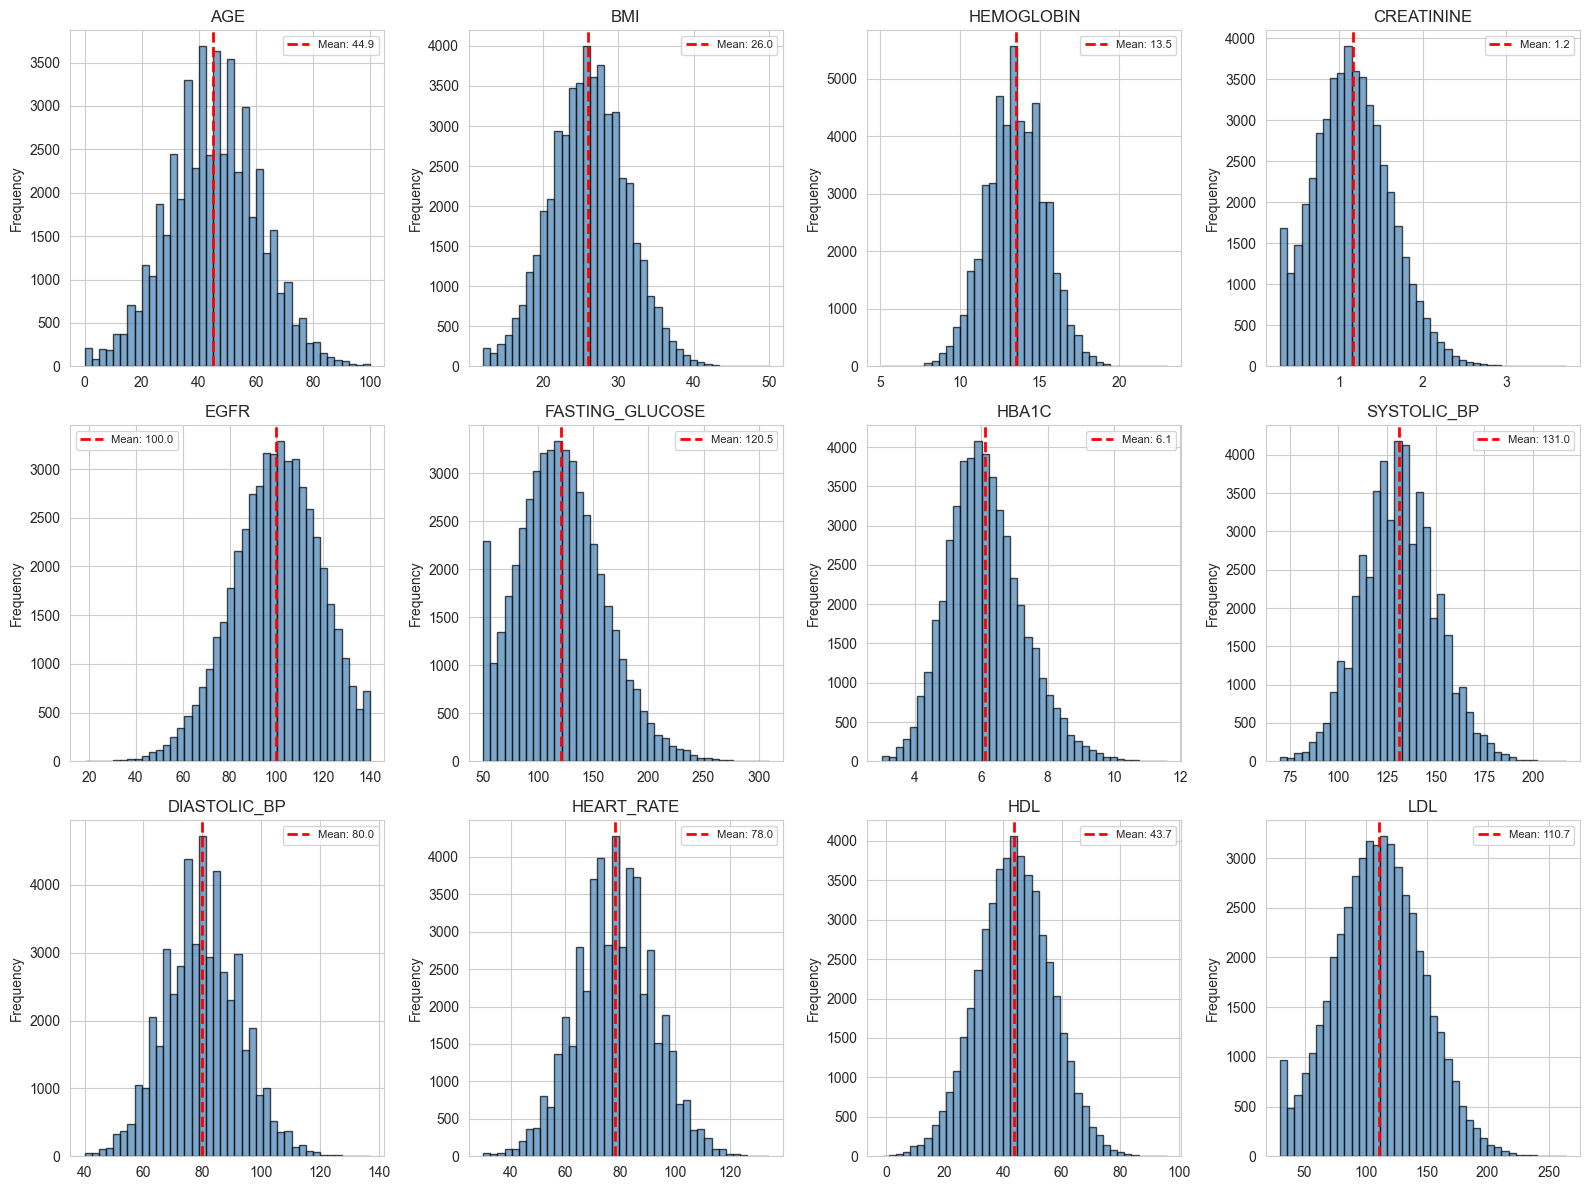

In [351]:
# Key clinical parameters distribution
key_features = ['age', 'bmi', 'hemoglobin', 'creatinine', 'egfr', 'fasting_glucose', 
                'hba1c', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'hdl', 'ldl']

# Filter to available features
key_features = [f for f in key_features if f in df.columns]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if idx < len(axes):
        data = df[col].dropna()
        axes[idx].hist(data, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{col.upper()}')
        axes[idx].set_ylabel('Frequency')
        
        # Add mean line
        mean_val = data.mean()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        axes[idx].legend(fontsize=8)

# Hide unused subplots
for idx in range(len(key_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [352]:
# Key features statistics
print("="*80)
print("KEY CLINICAL PARAMETERS STATISTICS")
print("="*80)
print(df[key_features].describe())


KEY CLINICAL PARAMETERS STATISTICS
                age           bmi    hemoglobin    creatinine          egfr  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      44.943180     26.017934     13.504788      1.163477     99.969784   
std       15.863553      5.016182      1.804341      0.446589     18.451080   
min        0.000000     12.000000      5.100000      0.300000     18.100000   
25%       34.000000     22.600000     12.300000      0.841677     87.700000   
50%       45.000000     26.000000     13.500000      1.142833    100.600000   
75%       56.000000     29.400000     14.700000      1.458762    113.100000   
max      100.000000     50.000000     23.000000      3.707958    140.000000   

       fasting_glucose         hba1c   systolic_bp  diastolic_bp   heart_rate  \
count     50000.000000  50000.000000  50000.000000  50000.000000  50000.00000   
mean        120.544536      6.124307    130.950640     79.979840     77.98810   
std       

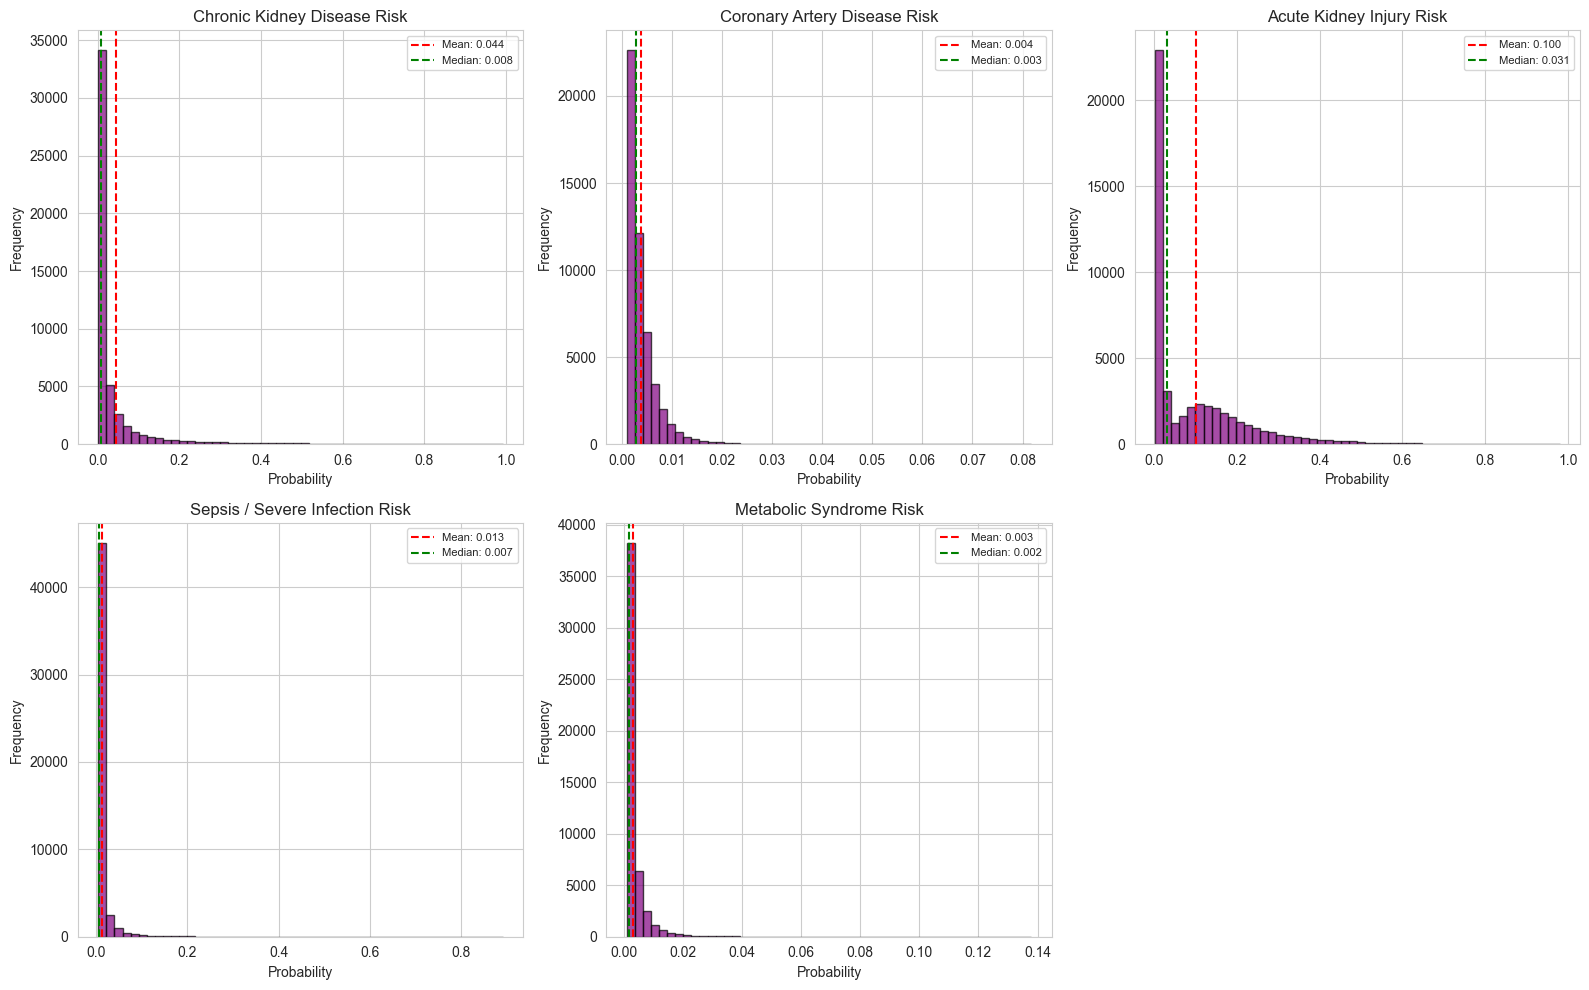

In [353]:
# Target distribution - Probabilities
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(TARGET_PROB_COLS):
    axes[idx].hist(df[col].dropna(), bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[idx].set_title(display_prob_name(col))
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xlabel('Probability')
    
    # Add statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.3f}')
    axes[idx].legend(fontsize=8)

if len(TARGET_PROB_COLS) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


In [354]:
# Probability statistics
print("="*80)
print("TARGET PROBABILITY STATISTICS")
print("="*80)
print(df[TARGET_PROB_COLS].describe())


TARGET PROBABILITY STATISTICS
       risk_ckd_prob  risk_cad_prob  risk_aki_prob  risk_sepsis_prob  \
count   50000.000000   50000.000000   50000.000000      50000.000000   
mean        0.044397       0.003873       0.100493          0.013355   
std         0.106421       0.003466       0.127158          0.027320   
min         0.001000       0.001000       0.002208          0.004941   
25%         0.001915       0.001704       0.009836          0.006381   
50%         0.007529       0.002862       0.030603          0.007262   
75%         0.032039       0.004810       0.156910          0.009238   
max         0.993716       0.081775       0.980652          0.891623   

       risk_metabolic_syndrome_prob  
count                  50000.000000  
mean                       0.003249  
std                        0.004626  
min                        0.001000  
25%                        0.001000  
50%                        0.001798  
75%                        0.003560  
max              

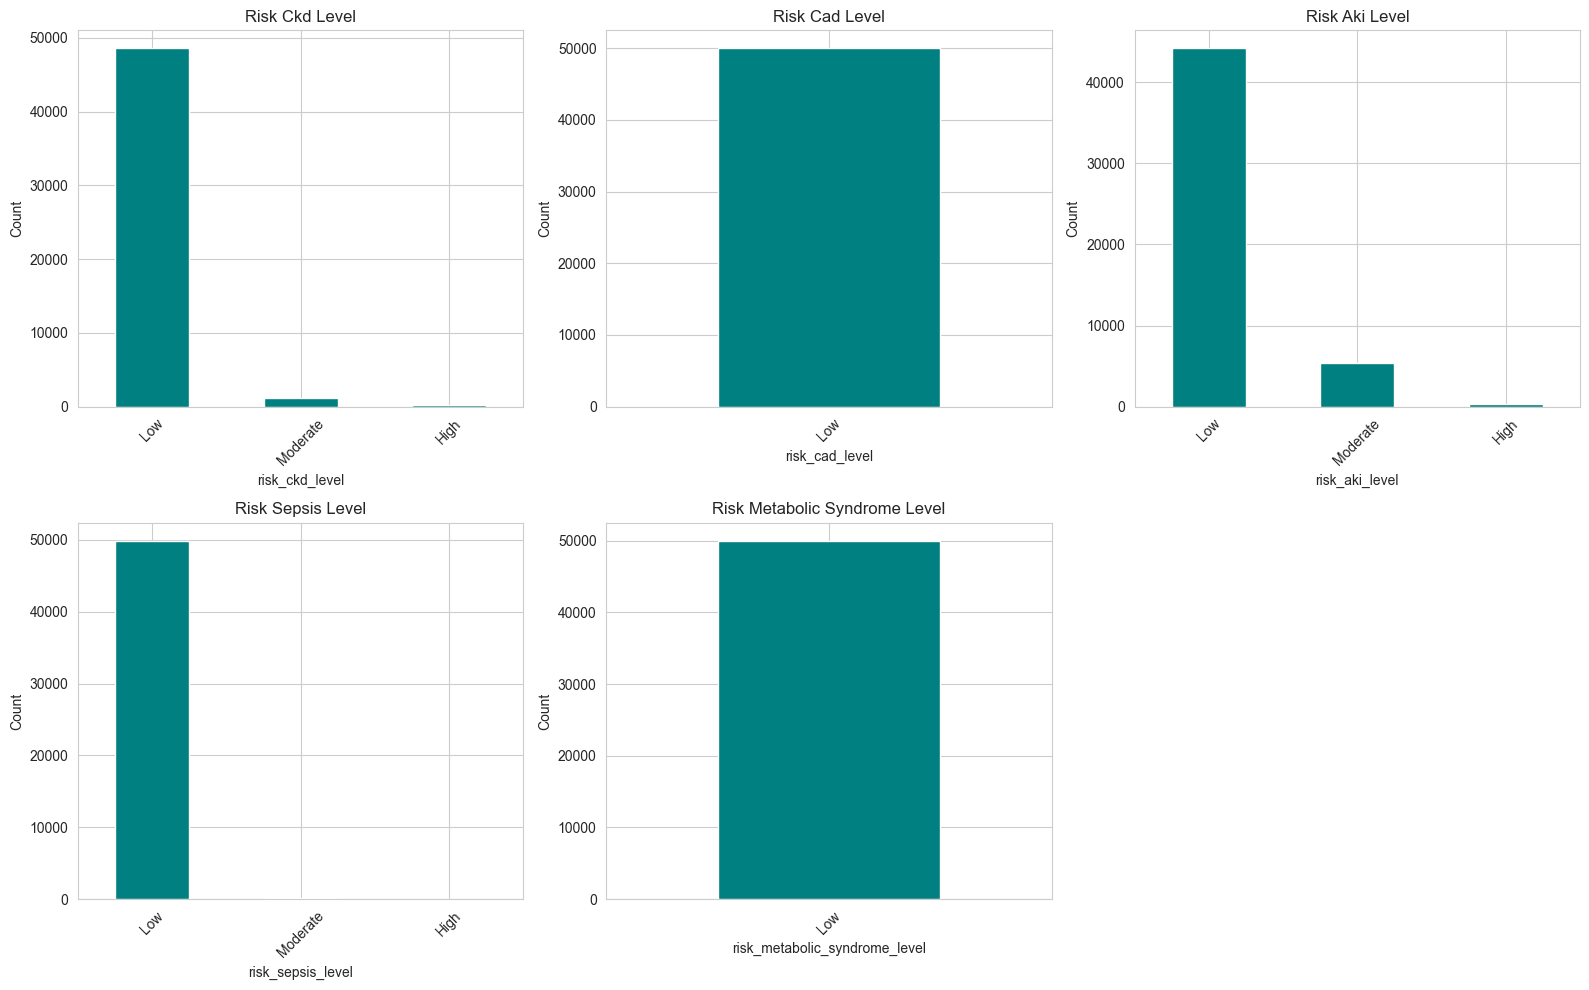

In [355]:
# Target distribution - Risk Levels
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(TARGET_LEVEL_COLS):
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='teal')
    axes[idx].set_title(col.replace('_', ' ').title())
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Hide the extra subplot
if len(TARGET_LEVEL_COLS) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


In [356]:
# Risk level distribution statistics
print("="*80)
print("RISK LEVEL DISTRIBUTIONS")
print("="*80)
for col in TARGET_LEVEL_COLS:
    print(f"\n{col}:")
    print(df[col].value_counts())


RISK LEVEL DISTRIBUTIONS

risk_ckd_level:
risk_ckd_level
Low         48576
Moderate     1211
High          213
Name: count, dtype: int64

risk_cad_level:
risk_cad_level
Low    50000
Name: count, dtype: int64

risk_aki_level:
risk_aki_level
Low         44198
Moderate     5434
High          368
Name: count, dtype: int64

risk_sepsis_level:
risk_sepsis_level
Low         49879
Moderate      109
High           12
Name: count, dtype: int64

risk_metabolic_syndrome_level:
risk_metabolic_syndrome_level
Low    50000
Name: count, dtype: int64


In [ ]:
# Class imbalance analysis
print("="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)
print("\nClass distribution percentages:")
for col in TARGET_LEVEL_COLS:
    dist = df[col].value_counts(normalize=True) * 100
    print(f"\n{col}:")
    for level, pct in dist.items():
        print(f"  {level:12s}: {pct:6.2f}%")
    


CLASS IMBALANCE ANALYSIS

Class distribution percentages:

risk_ckd_level:
  Low         :  97.15%
  Moderate    :   2.42%
  High        :   0.43%
  ⚠️  WARNING: Severely imbalanced (97.2% are 'Low')

risk_cad_level:
  Low         : 100.00%
  ⚠️  WARNING: Severely imbalanced (100.0% are 'Low')

risk_aki_level:
  Low         :  88.40%
  Moderate    :  10.87%
  High        :   0.74%

risk_sepsis_level:
  Low         :  99.76%
  Moderate    :   0.22%
  High        :   0.02%
  ⚠️  WARNING: Severely imbalanced (99.8% are 'Low')

risk_metabolic_syndrome_level:
  Low         : 100.00%
  ⚠️  WARNING: Severely imbalanced (100.0% are 'Low')


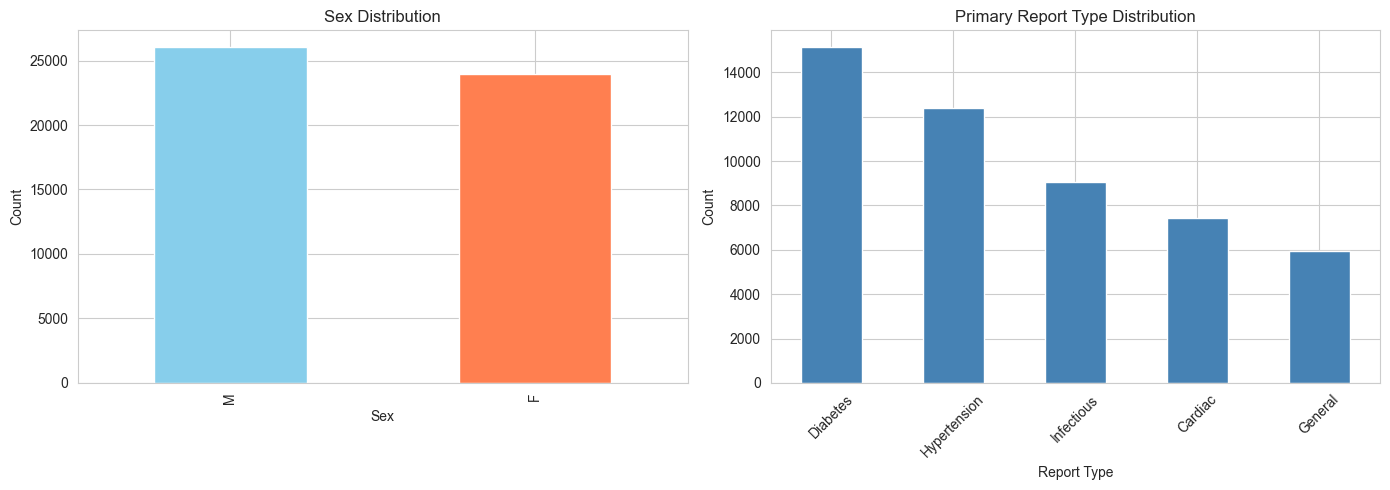

In [358]:
# Categorical features distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sex distribution
df['sex'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Sex Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Sex')

# Report type distribution
df['primary_report_type'].value_counts().plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Primary Report Type Distribution')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Report Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [359]:
# Categorical distribution statistics
print("="*80)
print("CATEGORICAL FEATURES STATISTICS")
print("="*80)
print("\nSex distribution:")
print(df['sex'].value_counts())
print("\nPrimary report type distribution:")
print(df['primary_report_type'].value_counts())


CATEGORICAL FEATURES STATISTICS

Sex distribution:
sex
M    26035
F    23965
Name: count, dtype: int64

Primary report type distribution:
primary_report_type
Diabetes        15133
Hypertension    12409
Infectious       9051
Cardiac          7447
General          5960
Name: count, dtype: int64


In [360]:
# Feature/target separation and type conversion
print("="*80)
print("FEATURE ENGINEERING & SEPARATION")
print("="*80)

feature_cols = [c for c in df.columns if c not in [ID_COL, *TARGET_PROB_COLS, *TARGET_LEVEL_COLS]]

# Convert binary flags to numeric
for col in BINARY_FLAG_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# Convert numeric features
for col in feature_cols:
    if col not in CATEGORICAL_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Handle extreme outliers (cap at 99th percentile for select features)
outlier_cap_features = ['creatinine', 'bun', 'ferritin', 'd_dimer', 'ntprobnp', 'troponin_hs']
for col in outlier_cap_features:
    if col in df.columns:
        upper_limit = df[col].quantile(0.99)
        df.loc[df[col] > upper_limit, col] = upper_limit

X = df[feature_cols].copy()
y_prob = df[TARGET_PROB_COLS].copy()
y_level = df[TARGET_LEVEL_COLS].replace(RISK_LEVEL_ORDER)

categorical_in_data = [c for c in CATEGORICAL_COLS if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_in_data]

print(f"Total features: {len(feature_cols)}")
print(f"Categorical: {len(categorical_in_data)} -> {categorical_in_data}")
print(f"Numeric: {len(numeric_cols)}")
print(f"\nTarget probabilities: {len(TARGET_PROB_COLS)}")
print(f"Target levels: {len(TARGET_LEVEL_COLS)}")


FEATURE ENGINEERING & SEPARATION
Total features: 40
Categorical: 2 -> ['sex', 'primary_report_type']
Numeric: 38

Target probabilities: 5
Target levels: 5


In [361]:
# Advanced preprocessing pipeline
print("="*80)
print("BUILDING PREPROCESSING PIPELINE")
print("="*80)

# Categorical transformer with imputation and one-hot encoding
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# Numeric transformer with imputation and scaling
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Combined preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_in_data),
        ("numeric", numeric_transformer, numeric_cols),
    ],
    remainder='drop'
)

print("Preprocessing pipeline created:")
print("- Categorical: Imputation (mode) + One-Hot Encoding")
print("- Numeric: Imputation (median) + Standardization")


BUILDING PREPROCESSING PIPELINE
Preprocessing pipeline created:
- Categorical: Imputation (mode) + One-Hot Encoding
- Numeric: Imputation (median) + Standardization


In [362]:
# Train/validation split
print("="*80)
print("TRAIN-VALIDATION SPLIT")
print("="*80)

X_train, X_val, y_prob_train, y_prob_val, y_level_train, y_level_val = train_test_split(
    X,
    y_prob,
    y_level,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=None  # No stratification needed for regression
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"\nFeature dimensions: {X_train.shape[1]}")
print(f"Target probability dimensions: {y_prob_train.shape[1]}")
print(f"Target level dimensions: {y_level_train.shape[1]}")


TRAIN-VALIDATION SPLIT
Training set: 40,000 samples (80.0%)
Validation set: 10,000 samples (20.0%)

Feature dimensions: 40
Target probability dimensions: 5
Target level dimensions: 5


## 3. Model Training

In [363]:
# Probability model (LightGBM regression)
print("="*80)
print("TRAINING PROBABILITY MODEL")
print("="*80)

regressor = MultiOutputRegressor(
    LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        verbose=-1,
    )
)

model_prob = Pipeline([
    ("preprocess", preprocess),
    ("model", regressor),
])

print("Training probability model...")
model_prob.fit(X_train, y_prob_train)

prob_pred = model_prob.predict(X_val)
rmse = {
    col: float(np.sqrt(mean_squared_error(y_prob_val[col], prob_pred[:, idx])))
    for idx, col in enumerate(TARGET_PROB_COLS)
}
mae = {
    col: float(mean_absolute_error(y_prob_val[col], prob_pred[:, idx]))
    for idx, col in enumerate(TARGET_PROB_COLS)
}

print("\nModel Performance:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Mean RMSE: {np.mean(list(rmse.values())):.4f}")
print(f"Mean MAE: {np.mean(list(mae.values())):.4f}")


TRAINING PROBABILITY MODEL
Training probability model...

Model Performance:
RMSE: {'risk_ckd_prob': 0.022065421277245274, 'risk_cad_prob': 0.0004992212489110005, 'risk_aki_prob': 0.016778450655555013, 'risk_sepsis_prob': 0.017024421662831836, 'risk_metabolic_syndrome_prob': 0.001231323565260662}
MAE: {'risk_ckd_prob': 0.00788709334955528, 'risk_cad_prob': 0.00019104115908121473, 'risk_aki_prob': 0.003713077999476887, 'risk_sepsis_prob': 0.001729356712641687, 'risk_metabolic_syndrome_prob': 0.0002567517117468815}
Mean RMSE: 0.0115
Mean MAE: 0.0028


In [364]:
# Helper function to derive risk levels from probabilities
def prob_to_level(p):
    """Convert probability to risk level category"""
    if p < 0.001:
        return "Very Low"
    elif p < 0.01:
        return "Low"
    elif p < 0.05:
        return "Moderate"
    elif p < 0.20:
        return "High"
    else:
        return "Critical"

# Derive risk levels from probability predictions
print("="*80)
print("DERIVING RISK LEVELS FROM PROBABILITIES")
print("="*80)

# Convert predictions to DataFrame for easier handling
prob_pred_df = pd.DataFrame(prob_pred, columns=TARGET_PROB_COLS)

# Derive risk levels
level_pred_df = prob_pred_df.applymap(prob_to_level)
level_pred_df.columns = [col.replace('_prob', '_level') for col in TARGET_PROB_COLS]

# Convert ground truth levels for comparison (0='Low', 1='Moderate', 2='High')
level_map = {0: 'Low', 1: 'Moderate', 2: 'High'}
y_level_val_labels = y_level_val.copy()
for col in y_level_val_labels.columns:
    y_level_val_labels[col] = y_level_val_labels[col].map(level_map)

# Calculate accuracy for derived levels
level_accuracy = {}
for idx, col in enumerate(TARGET_LEVEL_COLS):
    if col in y_level_val_labels.columns:
        acc = accuracy_score(y_level_val_labels[col], level_pred_df[col])
        level_accuracy[col] = acc

print("\nRisk Level Accuracy (derived from probabilities):")
for col, acc in level_accuracy.items():
    print(f"  {col}: {acc:.4f}")
print(f"\nMean Accuracy: {np.mean(list(level_accuracy.values())):.4f}")


DERIVING RISK LEVELS FROM PROBABILITIES

Risk Level Accuracy (derived from probabilities):
  risk_ckd_level: 0.4045
  risk_cad_level: 0.8939
  risk_aki_level: 0.2612
  risk_sepsis_level: 0.7923
  risk_metabolic_syndrome_level: 0.7846

Mean Accuracy: 0.6273


FEATURE IMPORTANCE ANALYSIS


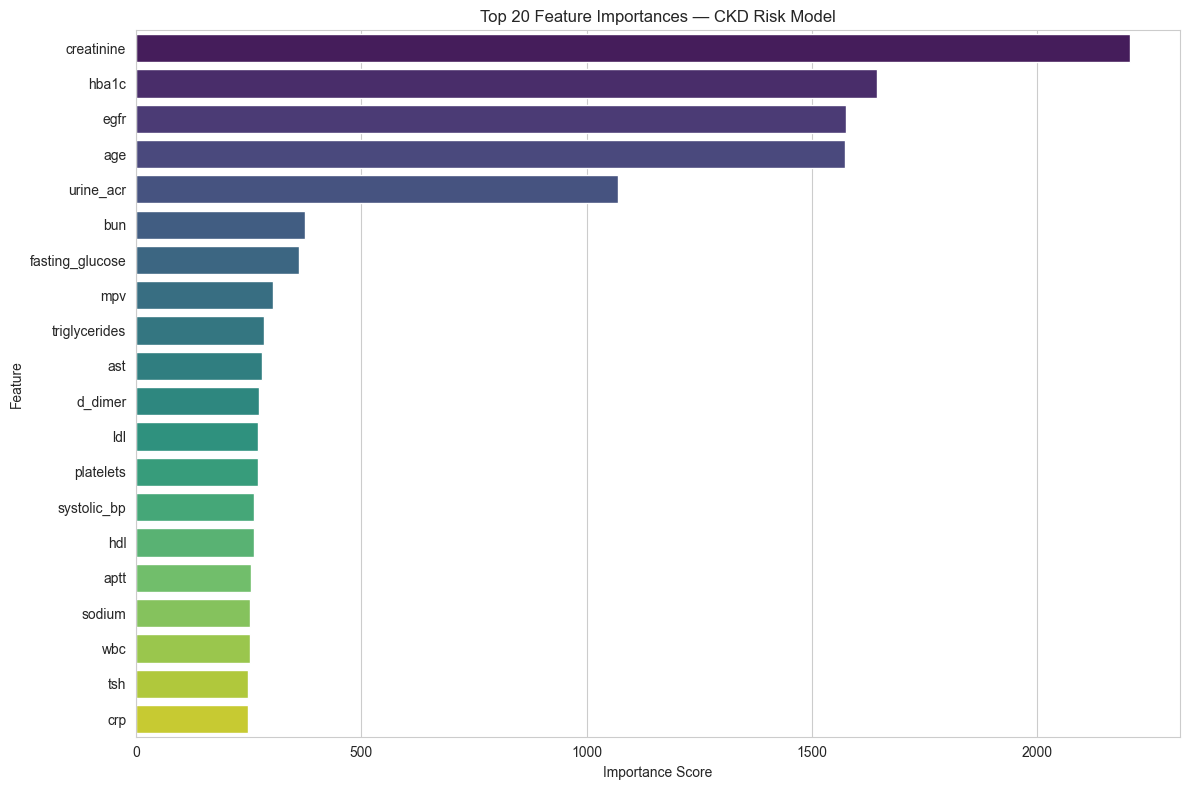


Top 20 Important Features:
        Feature  Importance
     creatinine        2207
          hba1c        1644
           egfr        1577
            age        1574
      urine_acr        1069
            bun         374
fasting_glucose         361
            mpv         303
  triglycerides         283
            ast         280
        d_dimer         274
            ldl         270
      platelets         270
    systolic_bp         261
            hdl         261
           aptt         256
         sodium         254
            wbc         253
            tsh         249
            crp         248


In [365]:
# Feature importance from LightGBM models
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature names after preprocessing
feature_names_out = []
# Categorical features (one-hot encoded)
if len(categorical_in_data) > 0:
    cat_encoder = preprocess.named_transformers_['categorical'].named_steps['onehot']
    feature_names_out.extend(cat_encoder.get_feature_names_out(categorical_in_data))
# Numeric features
feature_names_out.extend(numeric_cols)

# Extract feature importance from first disease model (CKD)
first_estimator = model_prob.named_steps['model'].estimators_[0]
importance = first_estimator.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importance
}).sort_values('Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances — CKD Risk Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 20 Important Features:")
print(importance_df.to_string(index=False))


CONFUSION MATRICES (Derived Levels)


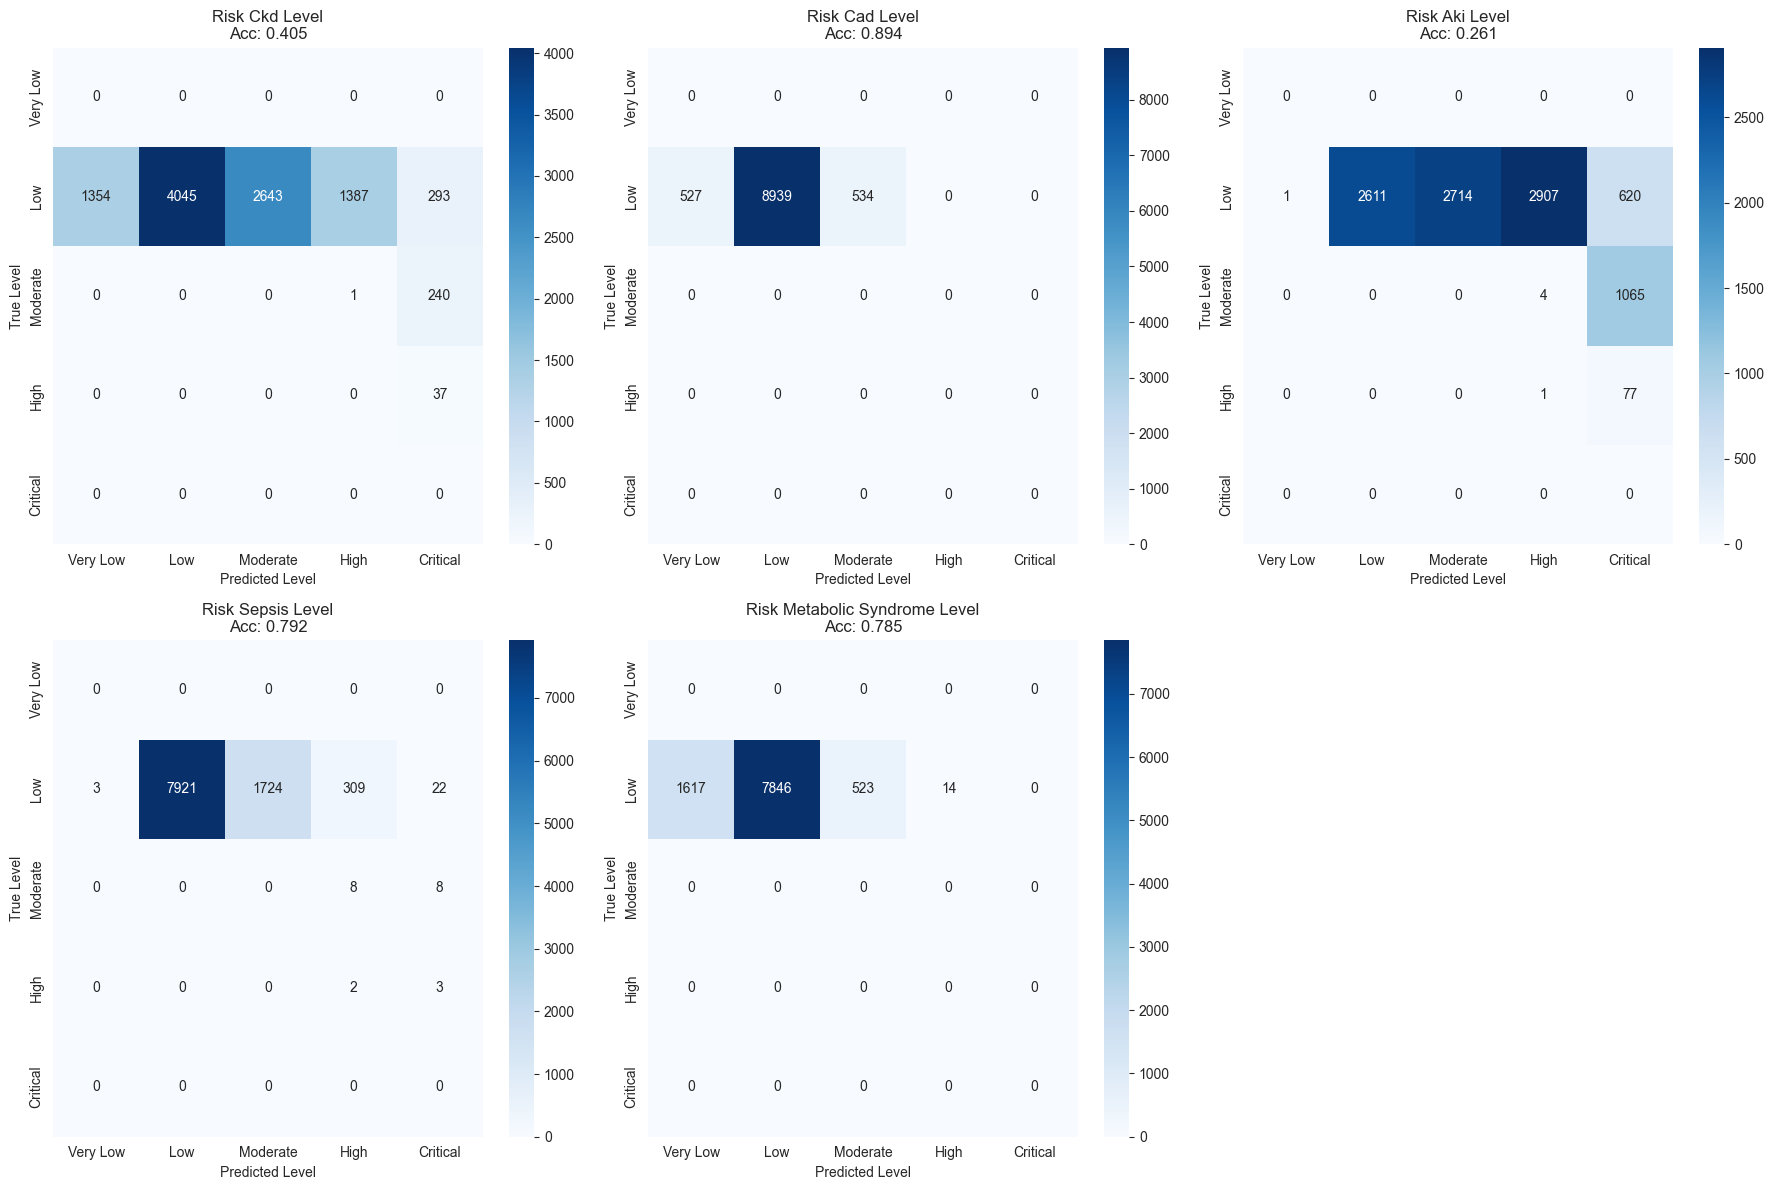

In [366]:
# Confusion matrices for derived risk levels
print("="*80)
print("CONFUSION MATRICES (Derived Levels)")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

level_names = ['Very Low', 'Low', 'Moderate', 'High', 'Critical']

for idx, col in enumerate(TARGET_LEVEL_COLS):
    if col in y_level_val_labels.columns:
        cm = confusion_matrix(y_level_val_labels[col], level_pred_df[col], labels=level_names)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=level_names, yticklabels=level_names)
        axes[idx].set_title(f'{col.replace("_", " ").title()}\nAcc: {level_accuracy[col]:.3f}')
        axes[idx].set_ylabel('True Level')
        axes[idx].set_xlabel('Predicted Level')

if len(TARGET_LEVEL_COLS) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


In [367]:
# Probability model evaluation metrics
print("="*80)
print("PROBABILITY MODEL EVALUATION (Regression)")
print("="*80)
metrics_df = pd.DataFrame({
    'Target': TARGET_PROB_COLS,
    'Display': [display_prob_name(col) for col in TARGET_PROB_COLS],
    'RMSE': [rmse[col] for col in TARGET_PROB_COLS],
    'MAE': [mae[col] for col in TARGET_PROB_COLS],
})
print(metrics_df[['Display', 'RMSE', 'MAE']].to_string(index=False))
print(f"\nAverage RMSE: {np.mean(list(rmse.values())):.4f}")
print(f"Average MAE: {np.mean(list(mae.values())):.4f}")


PROBABILITY MODEL EVALUATION (Regression)
                       Display     RMSE      MAE
   Chronic Kidney Disease Risk 0.022065 0.007887
  Coronary Artery Disease Risk 0.000499 0.000191
      Acute Kidney Injury Risk 0.016778 0.003713
Sepsis / Severe Infection Risk 0.017024 0.001729
       Metabolic Syndrome Risk 0.001231 0.000257

Average RMSE: 0.0115
Average MAE: 0.0028


In [368]:
# Model evaluation summary
print("="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

print("\nProbability Model (Regression):")
print("-" * 60)
metrics_df = pd.DataFrame({
    'Target': TARGET_PROB_COLS,
    'Display': [display_prob_name(col) for col in TARGET_PROB_COLS],
    'RMSE': [rmse[col] for col in TARGET_PROB_COLS],
    'MAE': [mae[col] for col in TARGET_PROB_COLS],
})
print(metrics_df[['Display', 'RMSE', 'MAE']].to_string(index=False))
print(f"\nAverage RMSE: {np.mean(list(rmse.values())):.4f}")
print(f"Average MAE: {np.mean(list(mae.values())):.4f}")

print("\nDerived Risk Levels (from probabilities):")
print("-" * 60)
level_df = pd.DataFrame({
    'Target': TARGET_LEVEL_COLS,
    'Accuracy': [level_accuracy[col] for col in TARGET_LEVEL_COLS if col in level_accuracy]
})
print(level_df.to_string(index=False))
print(f"\nAverage Accuracy: {np.mean(list(level_accuracy.values())):.4f}")

print("\n" + "="*80)
print("APPROACH:")
print("="*80)
print("Risk levels are derived from probability predictions using thresholds:")
print("  - Very Low:  p < 0.001")
print("  - Low:       0.001 <= p < 0.01")
print("  - Moderate:  0.01  <= p < 0.05")
print("  - High:      0.05  <= p < 0.20")
print("  - Critical:  p >= 0.20")
print("\nThis approach ensures consistency between probabilities and categorical levels.")


MODEL EVALUATION SUMMARY

Probability Model (Regression):
------------------------------------------------------------
                       Display     RMSE      MAE
   Chronic Kidney Disease Risk 0.022065 0.007887
  Coronary Artery Disease Risk 0.000499 0.000191
      Acute Kidney Injury Risk 0.016778 0.003713
Sepsis / Severe Infection Risk 0.017024 0.001729
       Metabolic Syndrome Risk 0.001231 0.000257

Average RMSE: 0.0115
Average MAE: 0.0028

Derived Risk Levels (from probabilities):
------------------------------------------------------------
                       Target  Accuracy
               risk_ckd_level    0.4045
               risk_cad_level    0.8939
               risk_aki_level    0.2612
            risk_sepsis_level    0.7923
risk_metabolic_syndrome_level    0.7846

Average Accuracy: 0.6273

APPROACH:
Risk levels are derived from probability predictions using thresholds:
  - Very Low:  p < 0.001
  - Low:       0.001 <= p < 0.01
  - Moderate:  0.01  <= p < 0.05
  

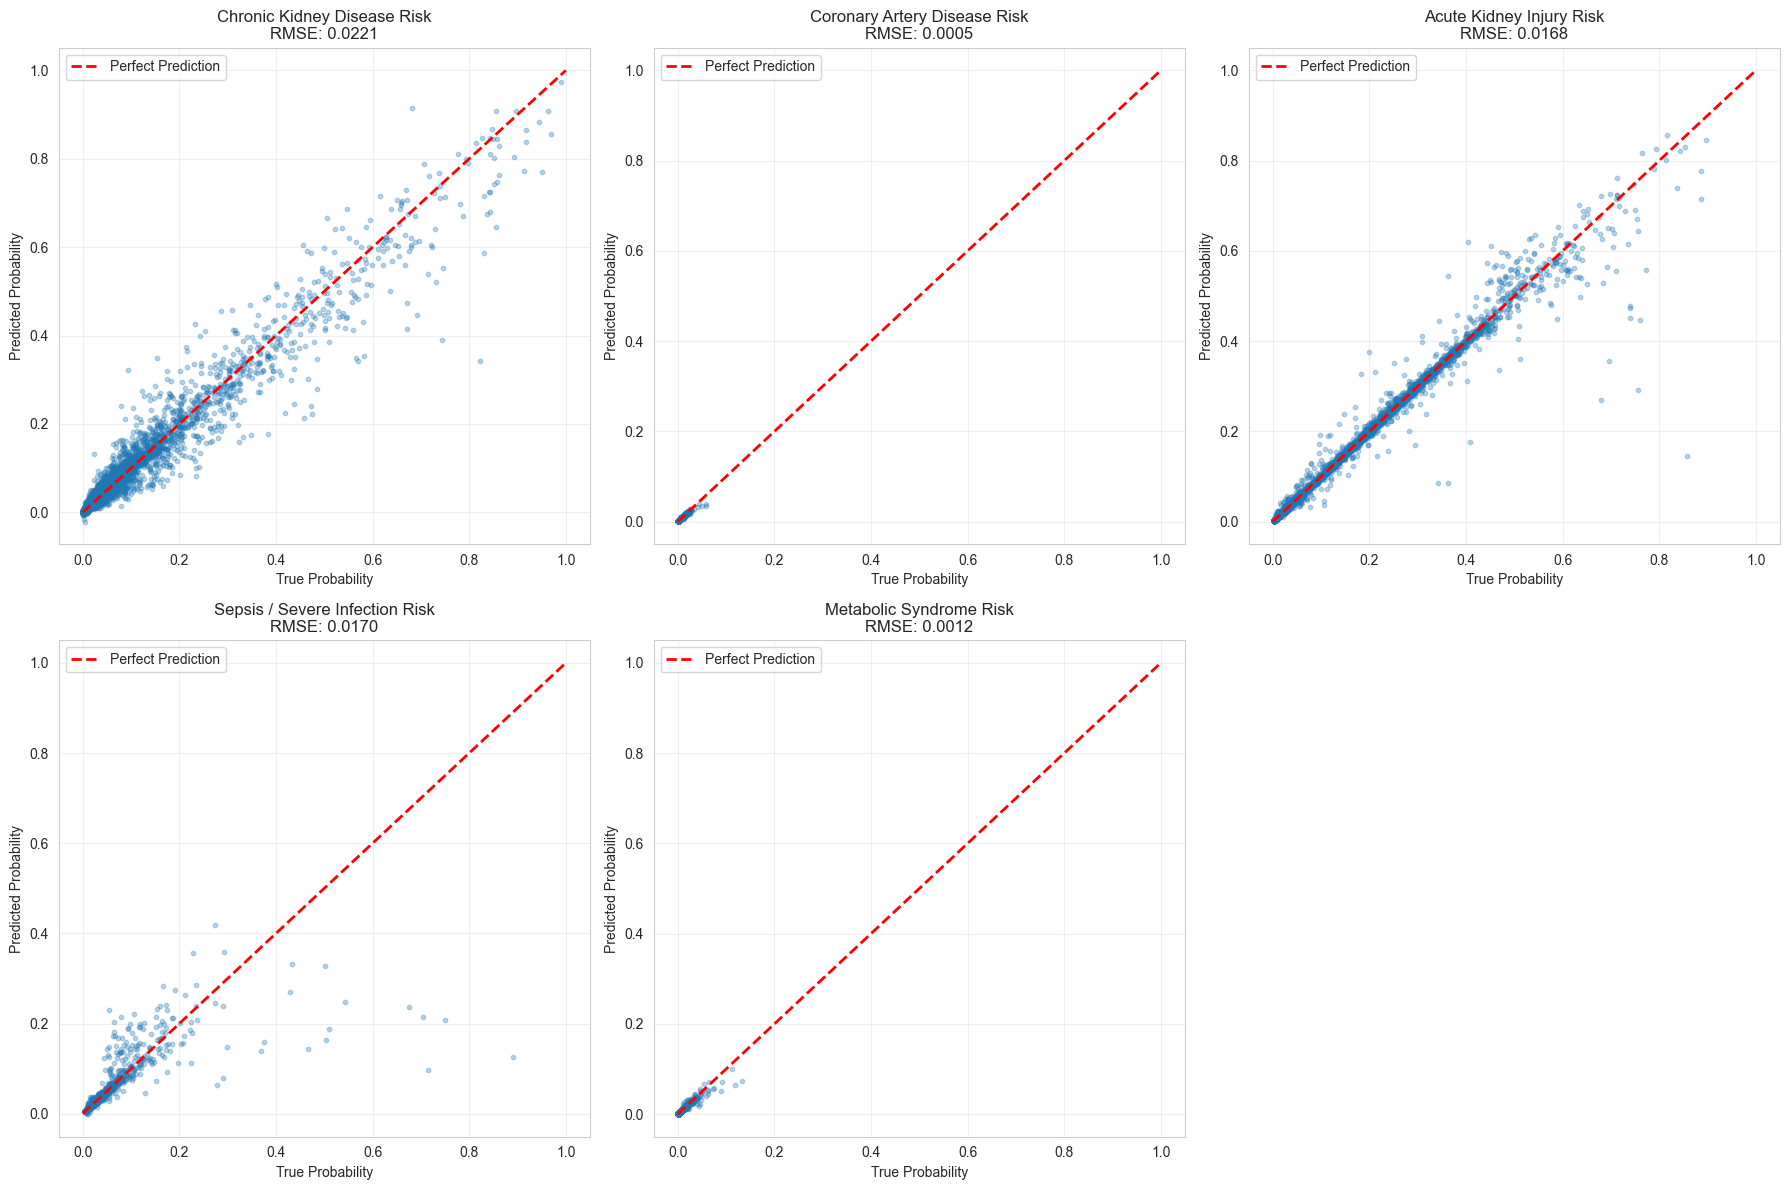

In [369]:
# Probability predictions visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(TARGET_PROB_COLS):
    axes[idx].scatter(y_prob_val[col], prob_pred[:, idx], alpha=0.3, s=10)
    axes[idx].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel('True Probability')
    axes[idx].set_ylabel('Predicted Probability')
    axes[idx].set_title(f"{display_prob_name(col)}\nRMSE: {rmse[col]:.4f}")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

if len(TARGET_PROB_COLS) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


## 4. Model Evaluation & Visualization

In [370]:
# Persist artifacts directly to trained_models folder
run_ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

# Save model
joblib.dump(model_prob, TRAINED_DIR / f"risk_prob_model_{run_ts}.pkl")

# Save metadata
metadata = {
    "timestamp_utc": run_ts,
    "model_type": "LightGBM",
    "prob_model": "LGBMRegressor (multi-output)",
    "n_estimators": 500,
    "learning_rate": 0.05,
    "categorical_cols": categorical_in_data,
    "numeric_cols": numeric_cols,
    "target_prob_cols": TARGET_PROB_COLS,
    "target_level_cols": TARGET_LEVEL_COLS,
    "rmse": rmse,
    "mae": mae,
    "level_accuracy": level_accuracy,
    "risk_level_thresholds": {
        "Very Low": "p < 0.001",
        "Low": "0.001 <= p < 0.01",
        "Moderate": "0.01 <= p < 0.05",
        "High": "0.05 <= p < 0.20",
        "Critical": "p >= 0.20"
    },
    "note": "Risk levels are derived from probability predictions using fixed thresholds."
}

with open(TRAINED_DIR / f"metadata_{run_ts}.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Models saved:")
print(f"  - {TRAINED_DIR / f'risk_prob_model_{run_ts}.pkl'}")
print(f"  - {TRAINED_DIR / f'metadata_{run_ts}.json'}")


Models saved:
  - d:\Volume E\PROJECTS\GDG_KrakenTech\GDG_KRAKENTECH_MEDWHISPER\models_store\trained_models\risk_prob_model_20260117_142705.pkl
  - d:\Volume E\PROJECTS\GDG_KrakenTech\GDG_KRAKENTECH_MEDWHISPER\models_store\trained_models\metadata_20260117_142705.json


## 5. Model Persistence & Deployment

In [371]:
# Inference helper

def prob_to_level(p):
    """Convert probability to risk level category"""
    if p < 0.001:
        return "Very Low"
    elif p < 0.01:
        return "Low"
    elif p < 0.05:
        return "Moderate"
    elif p < 0.20:
        return "High"
    else:
        return "Critical"

def predict_from_dict(sample: dict):
    """Predict disease risk probabilities and levels from patient data"""
    # Create DataFrame with all feature columns from training data
    # Fill with NaN initially
    df_sample = pd.DataFrame({col: [np.nan] for col in feature_cols})
    
    # Update with provided values
    for col in feature_cols:
        if col in sample:
            df_sample[col] = sample[col]
    
    # Convert numeric columns to numeric
    for col in numeric_cols:
        df_sample[col] = pd.to_numeric(df_sample[col], errors="coerce")
    
    # Predict probabilities
    prob_scores = model_prob.predict(df_sample)[0]
    
    # Derive risk levels from probabilities
    level_labels = [prob_to_level(p) for p in prob_scores]
    
    return {
        "probabilities": dict(zip(TARGET_PROB_COLS, prob_scores)),
        "levels": dict(zip(TARGET_LEVEL_COLS, level_labels)),
    }


In [373]:
# Example inference on sample patients
print("="*80)
print("EXAMPLE INFERENCE")
print("="*80)

# Sample patient with high risk indicators
sample_patient = {
  'age': 65,
  'sex': 'M',
  'bmi': 32.5,
  'primary_report_type': 'Diabetes',
  'hemoglobin': 11.2,
  'wbc': 7.5,
  'platelets': 180000,
  'creatinine': 2.8,
  'egfr': 25.5,
  'ast': 45,
  'alt': 52,
  'bilirubin_total': 1.2,
  'sodium': 138,
  'potassium': 4.5,
  'crp': 12.5,
  'fasting_glucose': 185,
  'hba1c': 8.9,
  'ppbs': 245,
  'triglycerides': 280,
  'hdl': 32,
  'ldl': 145,
  'systolic_bp': 144,
  'diastolic_bp': 92,
  'heart_rate': 82,
  'bun': 45,
  'urine_acr': 450,
  'dengue_ns1': 0,
  'dengue_igm': 0,
  'malaria_rdt': 0,
  'rapid_creatinine_rise_flag': 1
}

result = predict_from_dict(sample_patient)

print("\nSample Patient Profile:")
print(f"  Age: {sample_patient['age']}, Sex: {sample_patient['sex']}, BMI: {sample_patient['bmi']}")
print(f"  Primary Report Type: {sample_patient['primary_report_type']}")
print(f"  Key Labs: Creatinine={sample_patient['creatinine']}, eGFR={sample_patient['egfr']}, HbA1c={sample_patient['hba1c']}")

print("\nPredicted Risk Probabilities:")
for disease, prob in result['probabilities'].items():
  print(f"  {display_prob_name(disease)}: {prob:.4f}")

print("\nDerived Risk Levels:")
for disease, level in result['levels'].items():
  print(f"  {display_prob_name(disease.replace('_level', '_prob'))}: {level}")


EXAMPLE INFERENCE

Sample Patient Profile:
  Age: 65, Sex: M, BMI: 32.5
  Primary Report Type: Diabetes
  Key Labs: Creatinine=2.8, eGFR=25.5, HbA1c=8.9

Predicted Risk Probabilities:
  Chronic Kidney Disease Risk: 1.0633
  Coronary Artery Disease Risk: 0.0175
  Acute Kidney Injury Risk: 0.6836
  Sepsis / Severe Infection Risk: 0.0079
  Metabolic Syndrome Risk: 0.0437

Derived Risk Levels:
  Chronic Kidney Disease Risk: Critical
  Coronary Artery Disease Risk: Moderate
  Acute Kidney Injury Risk: Critical
  Sepsis / Severe Infection Risk: Low
  Metabolic Syndrome Risk: Moderate
